# AI Project 1 :  Tile Puzzle Solver
Spencer Hann  
CS 541 | Winter 2019

## Heuristics

### Heuristic 0: Misplaced Tiles Heuristic
```cython
cdef int misplaced_tiles_heuristic(int[:,::1] board) nogil:
    cdef:
        size_t i, j
        int idim
        int count = 0
        int dim = board.shape[0] # should be same as shape[1]

    for i in range(dim):
        idim = i * dim
        for j in range(dim):
            if board[i,j] == 0: continue
            if board[i,j]-1 != idim + j:
            # board[i,j]-1: -1 corrects for indexing (1 belongs at index 0)
                count += 1

    return count
```
The `misplaced_tiles_heuristic` simply runs through the current board state, and counts the number of tiles that are not yet where they should be.

### Heuristic 1: Manhattan Distance Heuristic
```cython
cdef int distance_tiles_heuristic(int[:,::1] board):
    cdef:
        long i, j
        int val
        int count = 0
        int dim = board.shape[0] # should be same as shape[1]

    for i in range(dim):
        for j in range(dim):
            val = board[i,j]
            if val == 0: continue
            val -= 1 # correct for indexing
            count += abs(val / dim - i) # distance in rows
            count += abs(val % dim - j) # distance in columns

    return count
```
The "Manhattan Distance" `distance_tiles_heuristic`, similar to heuristic 0, checks whether or not tiles are where they should be on the board. However, rather than simply counting the number of out of place tiles, it determines how far a tile is from its goal state location.

### Heuristic 2: Number of Inversions Heuristic
```cython
cdef int num_inversions_heuristic(int[:,::1] tmp):
# count the number of tiles that are before a smaller tile
    cdef:
        size_t i, j, k = 0
        int count = 0
        int[::1] board = np.empty(tmp.shape[0] * tmp.shape[1],dtype=np.intc)

    for i in range(tmp.shape[0]):
        for j in range(tmp.shape[1]):
            board[k] = tmp[i,j]
            k += 1

    for i in board:
        for j in board[i:]:
            if j == 0: continue
            if j < i:
                count += 1
    return count
```
To determine if an initial state is solvable or not, you must determine the number of inversions.
The number of inversions is the number of ordered pairs $(a,b)$ where $a$ occurs somewhere before $b$ in the sequence, but $a > b$. The goal state has 0 inversions.
For example, $[\ 1\ 3\ \_\ 2\ ]$, has one inversion, $(3,2)$, and $[\ 3\ 1\ \_\ 2\ ]$ has two inversions, $(3,1)$ and $(3,2)$. Notice that the second example is solvable, while the first, is not.  
By considering the parity of the number of inversions relative to the board size, and position of the empty space, you can detemine whether or not an initial configuration is impossible or solvable.
Because this was such a simple way to determine the solvability of a puzzle state, I wanted to experiment with using inversions as a heuristic.

### Heuristic 3: Max(Number of Inversion, Manhattan Distance)
```cython
cdef int manhattan_inversion_heuristic(int[:,::1] board):
#    return max(num_inversions_heuristic(board),distance_tiles_heuristic(board))
    cdef int inv = num_inversions_heuristic(board)
    cdef int man = distance_tiles_heuristic(board)
    if man > inv:
        return man
    return inv
```
This is a hybrid heuristic function that combines the most successful two from above.

## Results

In [1]:
import tile_puzzle_solver

In [2]:
tile_puzzle_solver.run_tests()

A* search
	Heuristic 0
		solved puzzle 0 in 22 steps.
		solved puzzle 1 in 25 steps.
		solved puzzle 2 in 21 steps.
		solved puzzle 3 in 22 steps.
		solved puzzle 4 in 18 steps.
		Average number of steps: 21.6

	Heuristic 1
		solved puzzle 0 in 22 steps.
		solved puzzle 1 in 25 steps.
		solved puzzle 2 in 21 steps.
		solved puzzle 3 in 22 steps.
		solved puzzle 4 in 18 steps.
		Average number of steps: 21.6

	Heuristic 2
		solved puzzle 0 in 22 steps.
		solved puzzle 1 in 25 steps.
		solved puzzle 2 in 21 steps.
		solved puzzle 3 in 22 steps.
		solved puzzle 4 in 18 steps.
		Average number of steps: 21.6

	Heuristic 3
		solved puzzle 0 in 22 steps.
		solved puzzle 1 in 25 steps.
		solved puzzle 2 in 21 steps.
		solved puzzle 3 in 22 steps.
		solved puzzle 4 in 18 steps.
		Average number of steps: 21.6

Best-first search
	Heuristic 0
		solved puzzle 0 in 811 steps.
		solved puzzle 1 in 4468 steps.
		solved puzzle 2 in 133 steps.
		solved puzzle 3 in 1242 steps.
		solved puzzle 4 in 707 

For A* search, the path lengths will always be the same, provided you selected a good heuristic. However, just because the final results are the same does not necessarily they perform exactly the same. Some heuristics take a significantly longer time to to compute that path. I think this is because some require a much broader exploration of the state space. That is to say, they find a lot more "dead ends" before doubling back to the the best option. Since they all produce paths of the same length, the best way to evaluate them is by minimizing runtime. Excluding my hybrid heuristic functino, the Manhattan Distance Heuristic took much less time than the others.  

For Best-first search, the path lengths differed greatly between heuristic. However, the Best-first runtimes were much quicker than A* search. This is important depending on the application. If what is needed is for the algorigthm to produce some best path, and that information is valuable for its own sake, then A* search is better. However, if what is needed is for some computer system to solve a problem quickly (determine a path and take it), then Best-first search is better.  

In this instance, solving the 8-tile puzzle, it would appear that Best-first search is actually the better algorithm for the job, because, even though it doesn't take the best path, it solves the problem faster, which is what is important. If the problem was to decide what freeways to take, A* star would be better, because, while Best-first would get you some solution faster, it might not be a very good one.

### A* runtimes

100%|██████████| 50/50 [03:30<00:00,  4.20s/it]


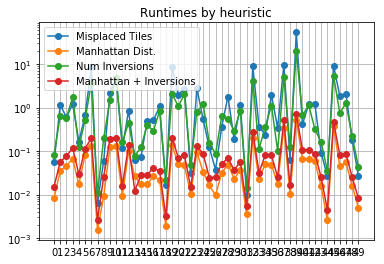

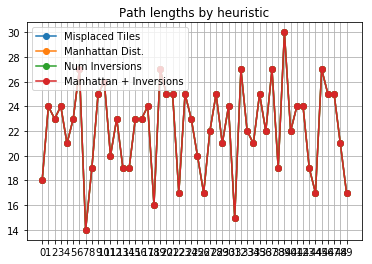

In [3]:
tile_puzzle_solver.show_plots('a', runs=50)

100%|██████████| 10/10 [00:23<00:00,  1.62s/it]


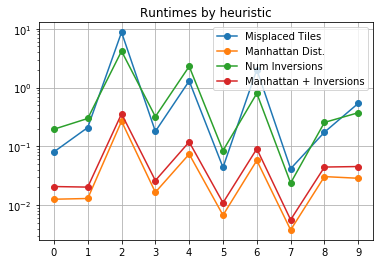

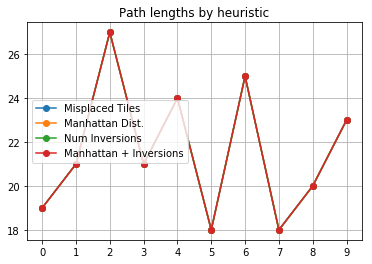

In [4]:
tile_puzzle_solver.show_plots('a')

### Best-first runtimes

100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


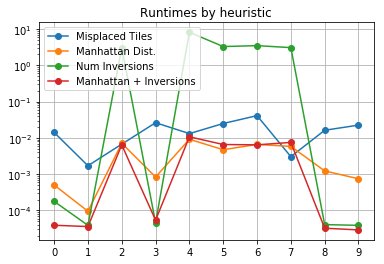

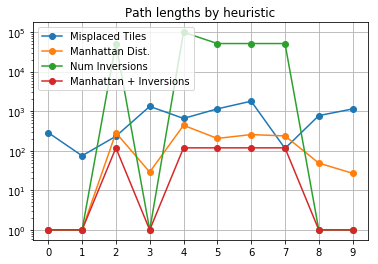

In [5]:
tile_puzzle_solver.show_plots("bf")